# 15.776 HODL Project

## I. Curating our own dataset - Extract News Data

Source: refinitive

Also tried: seeking alpha, yahoo finance, and reddit, but not enough data comparing to refinitve

### Data Coverage

Company list: 200 comps

1. US list company on NYSE and NASDAQ
2. Technology Sector according to LSEG workspace
3. Market Cap top 200: We have tried top 600 but smaller companies do not have as frequent news coverage as the larger ones
4. Time horizon: from 2024-09-10 to 2025-12-04


### A. Refinitive News Data

We extract news data from LSEG workspace, we would attach our code in another file. Our result is news.csv. The screenshots of extracting data at local Refinitiv Workspace are attached as below.

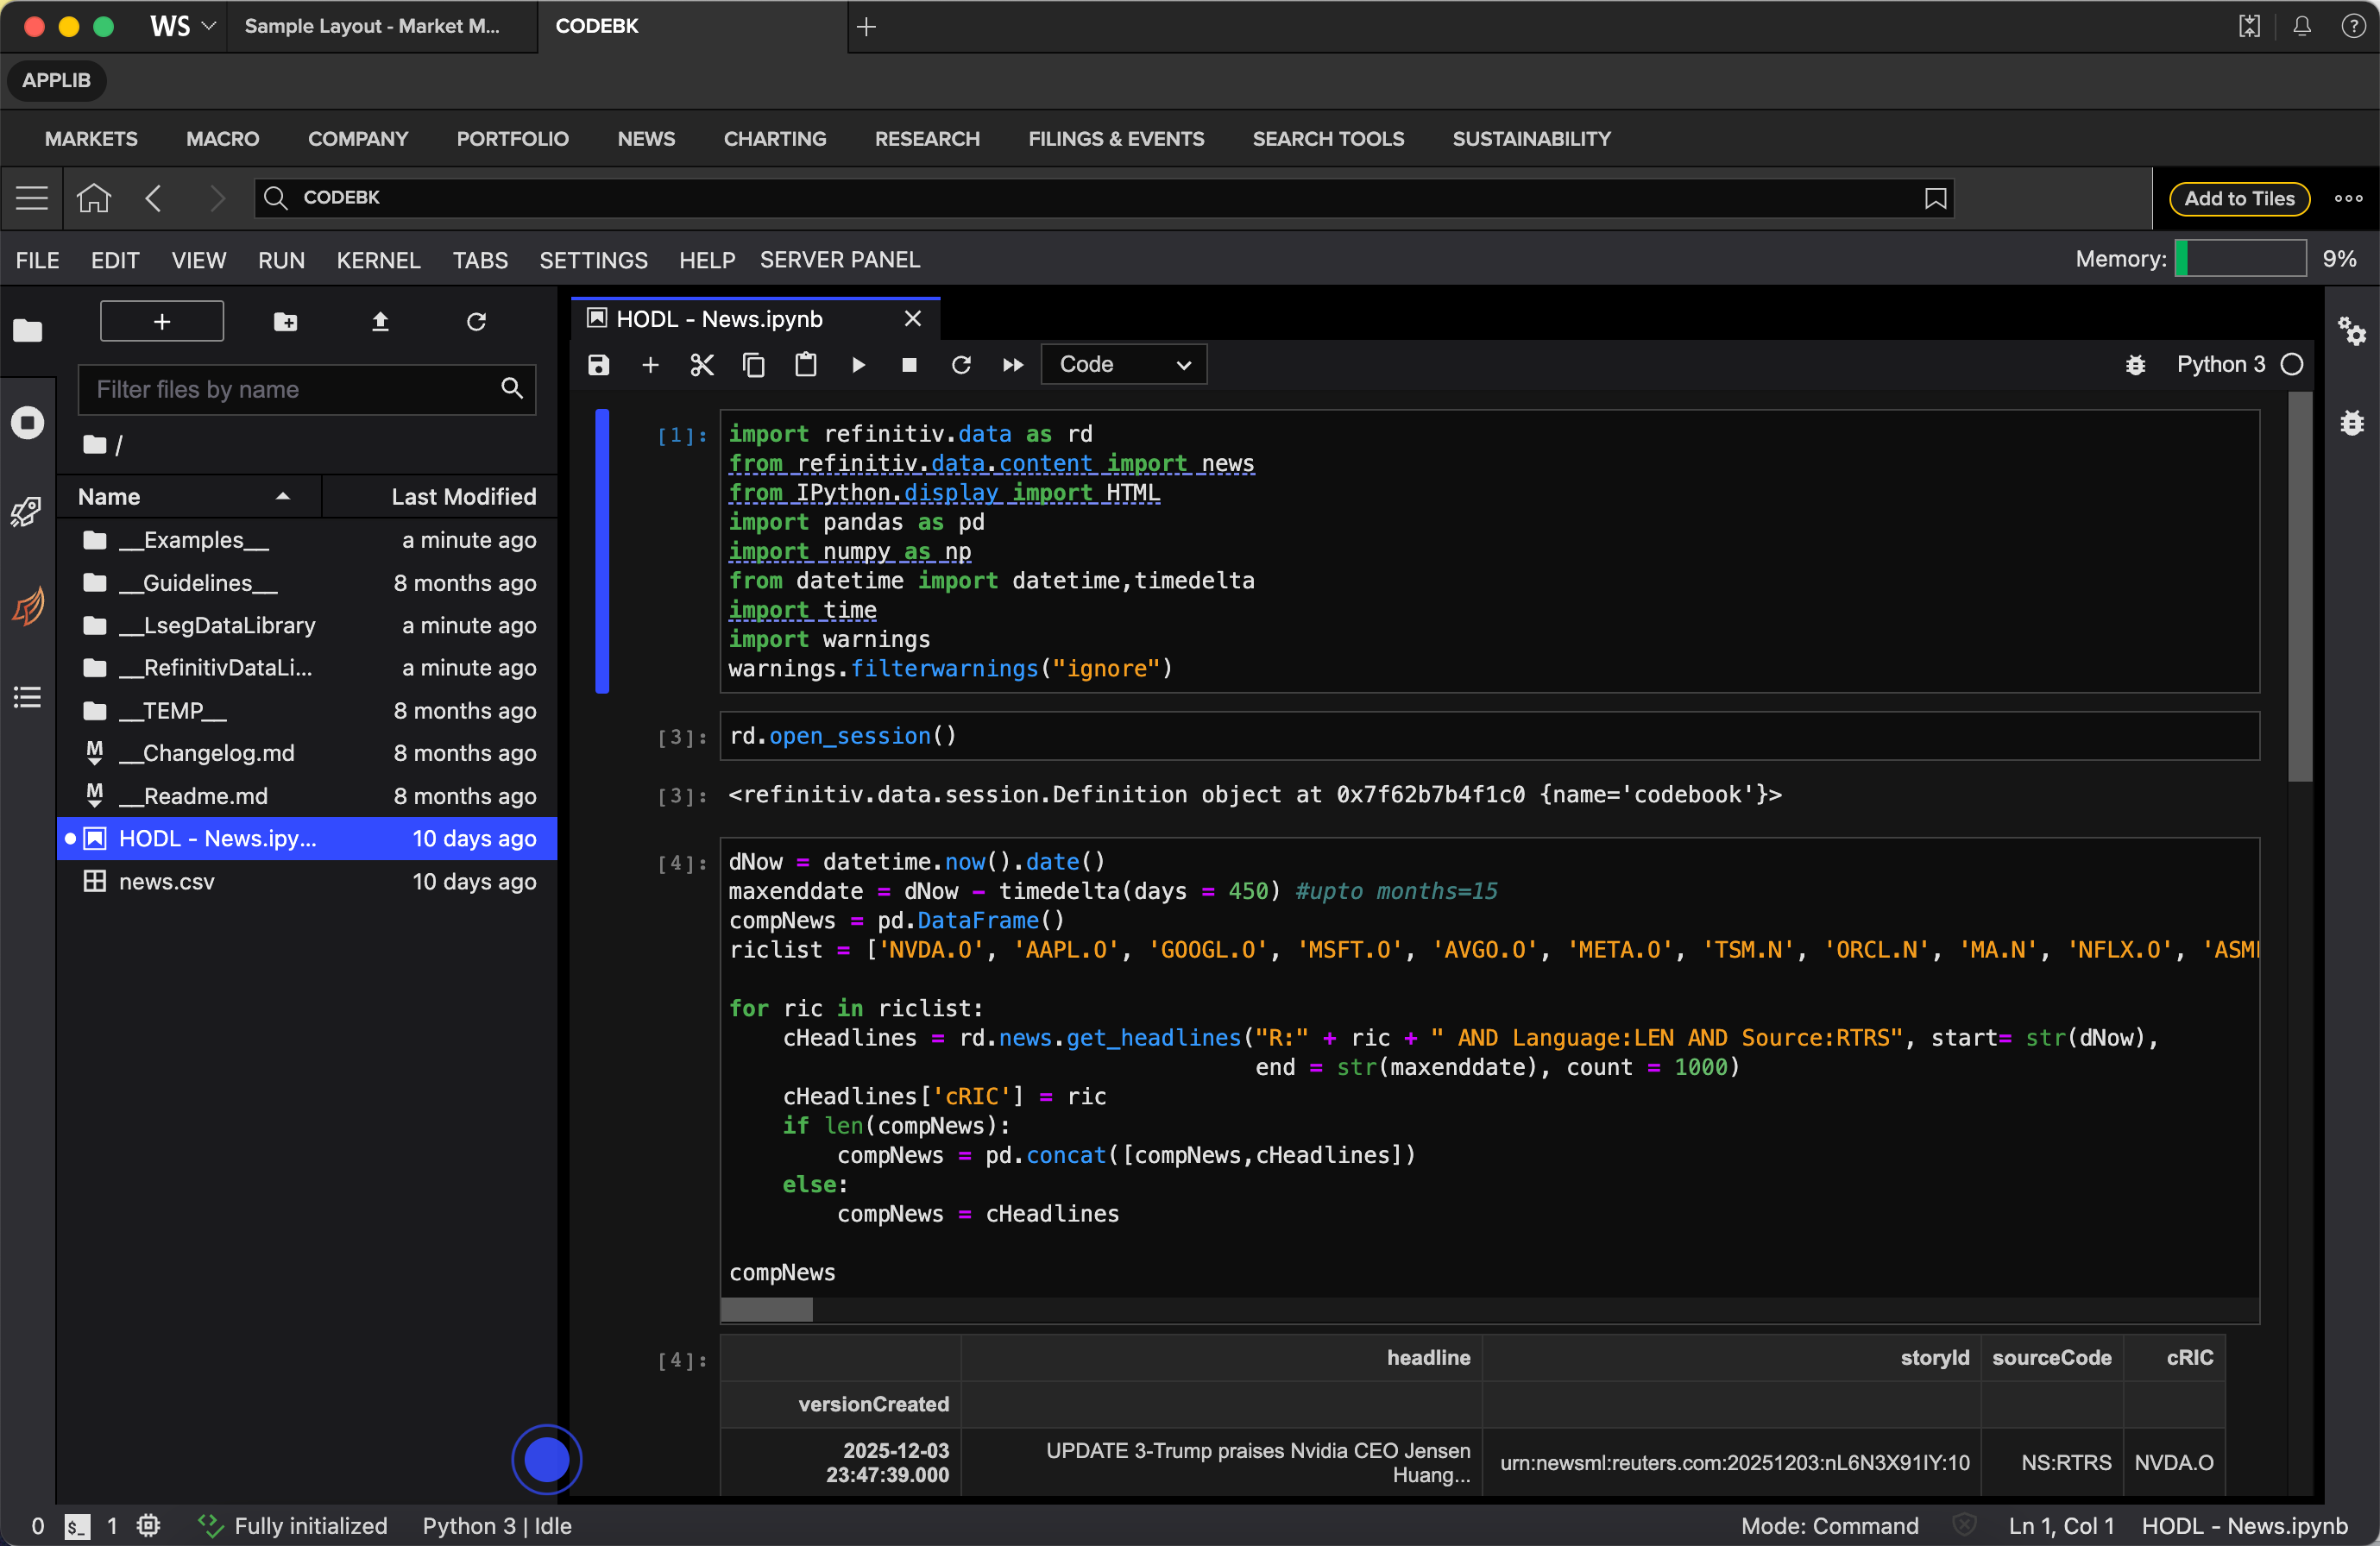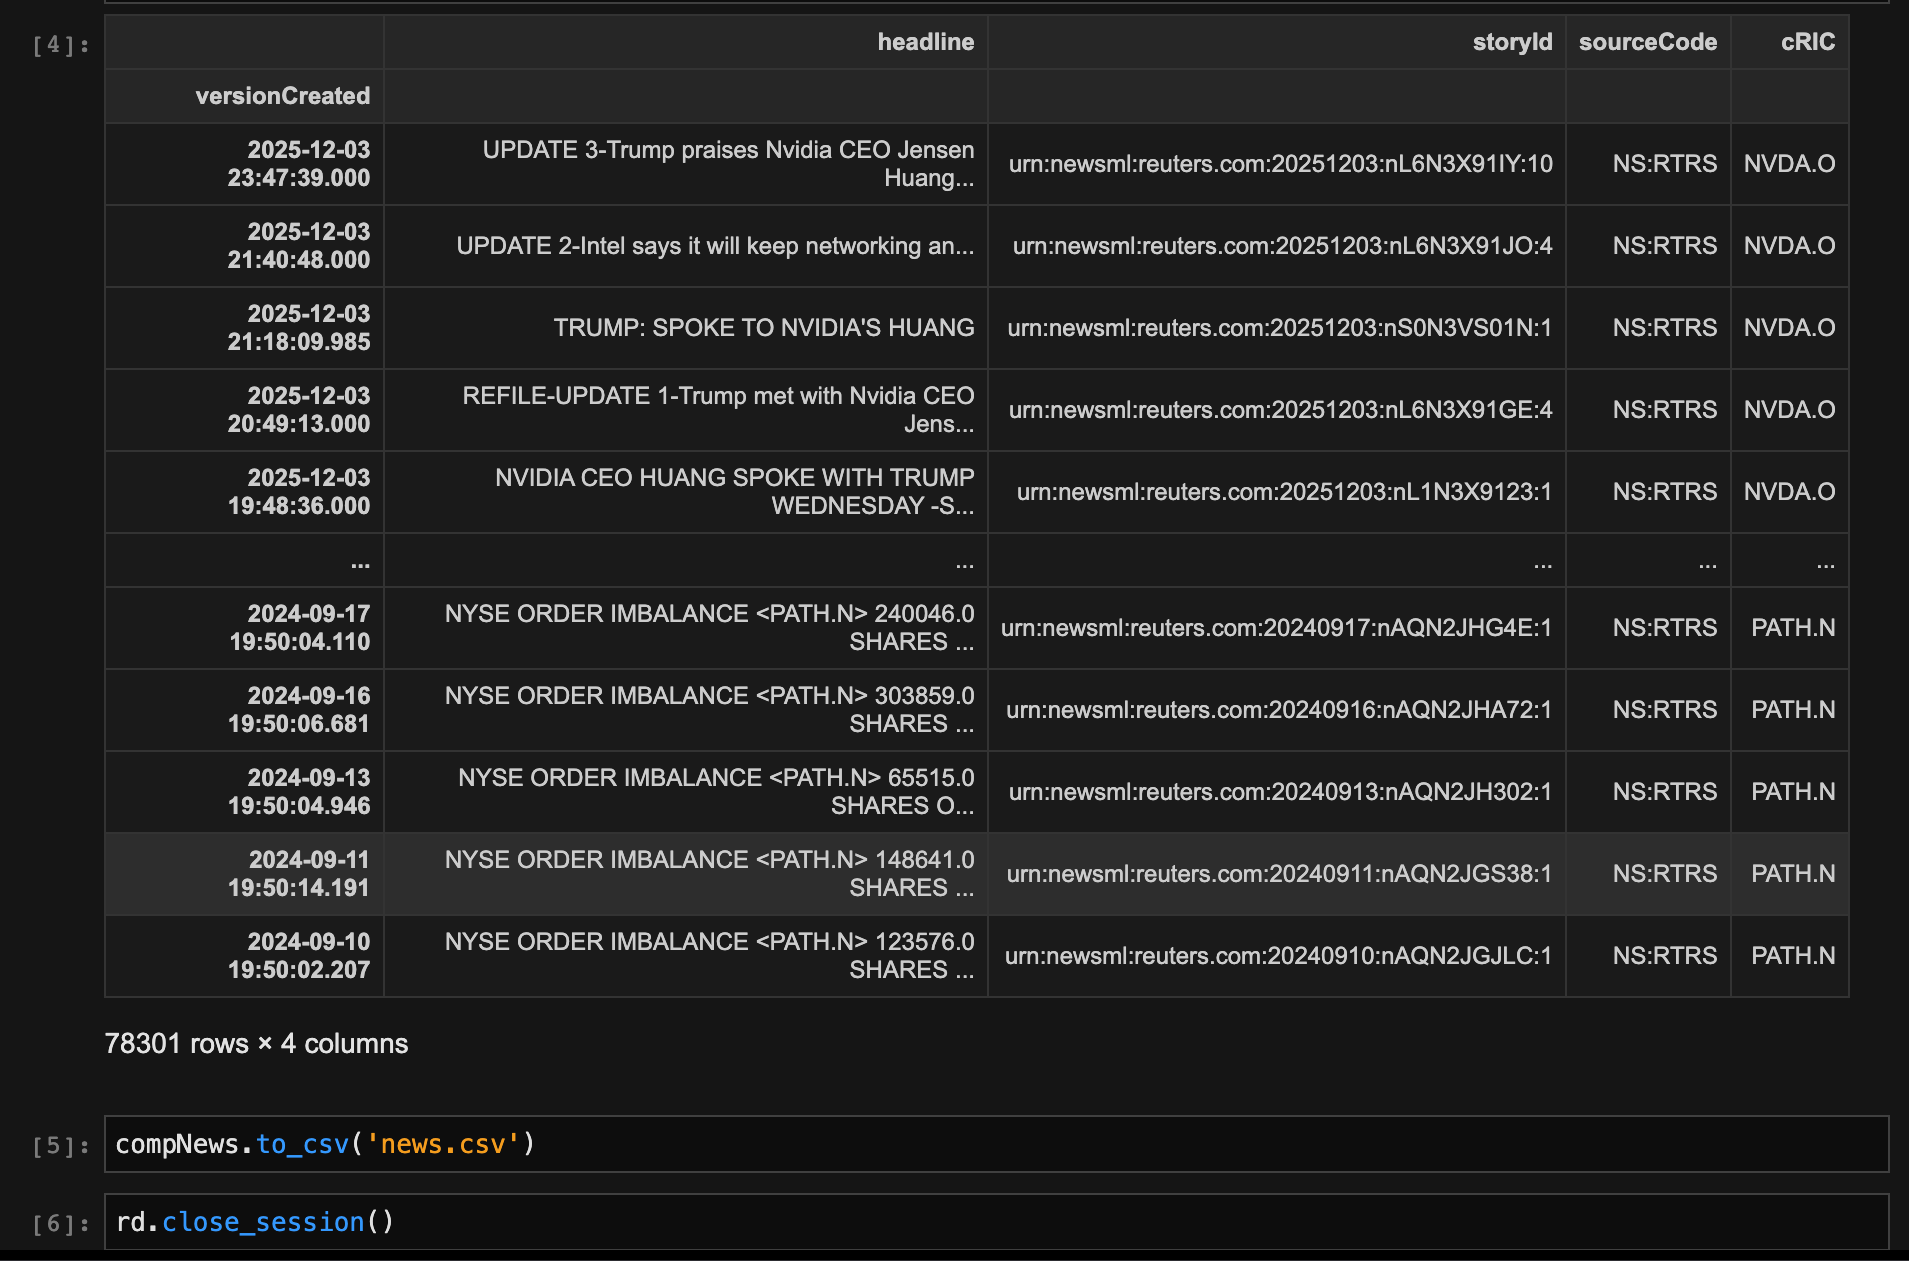

### B. Extract daily prices

In [5]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta

tickers = ["AAPL"]

def get_history(tickers, period="1y", interval="1d"):
    dfs = []
    for t in tickers:
        df = yf.Ticker(t).history(
            period=period,
            interval=interval,
            auto_adjust=False,
            actions=False,
            repair=True,
        )
        df["Ticker"] = t
        dfs.append(df)

    return pd.concat(dfs).reset_index()

df_prices = get_history(tickers)
df_prices

,Date,Open,High,Low,Close,Adj Close,Volume,Repaired?,Ticker
0,2024-12-13 00:00:00-05:00,247.820007,249.289993,246.240005,248.130005,247.012817,33155300,False,AAPL
1,2024-12-16 00:00:00-05:00,247.990005,251.380005,247.649994,251.039993,249.909714,51694800,False,AAPL
2,2024-12-17 00:00:00-05:00,250.080002,253.830002,249.779999,253.479996,252.338730,51356400,False,AAPL
3,2024-12-18 00:00:00-05:00,252.160004,254.279999,247.740005,248.050003,246.933182,56774100,False,AAPL
4,2024-12-19 00:00:00-05:00,247.500000,252.000000,247.089996,249.789993,248.665344,60882300,False,AAPL
...,...,...,...,...,...,...,...,...,...
245,2025-12-08 00:00:00-05:00,278.130005,279.670013,276.149994,277.890015,277.890015,38211800,False,AAPL
246,2025-12-09 00:00:00-05:00,278.160004,280.029999,276.920013,277.179993,277.179993,32193300,False,AAPL
247,2025-12-10 00:00:00-05:00,277.750000,279.750000,276.440002,278.779999,278.779999,33038300,False,AAPL
248,2025-12-11 00:00:00-05:00,279.100006,279.589996,273.809998,278.029999,278.029999,33248000,False,AAPL


## II. Building NLP Model

### A. Dataframe preprocessing



* Following the data extraction steps outlined above, we collected 78,301 news headlines related to 200 companies over a 15-month period.
* We conducted basic data preprocessing, including time conversion, ticker extraction, company name mapping, cleaning of headline, and creation of new column that combines companyname and headline as nlp model inputs.

In [6]:
import pandas as pd
import yfinance as yf
from google.colab import files
from sklearn.metrics import classification_report, accuracy_score

In [7]:
! wget https://raw.githubusercontent.com/ShirleyH17/HODL_Project/refs/heads/main/news.csv

--2025-12-14 19:33:55--  https://raw.githubusercontent.com/ShirleyH17/HODL_Project/refs/heads/main/news.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12505941 (12M) [text/plain]
Saving to: ‘news.csv’

news.csv            100%[===================>]  11.93M  --.-KB/s    in 0.02s   

2025-12-14 19:33:56 (500 MB/s) - ‘news.csv’ saved [12505941/12505941]



In [8]:
rnews_df = pd.read_csv('news.csv')

In [9]:
# extracting relevant columns and renaming
rnews_df = rnews_df[['versionCreated', 'headline', 'cRIC']]
rnews_df.columns = ['time', 'headline', 'cRIC']

# extracting ticker
rnews_df['ticker'] = rnews_df['cRIC'].str.replace(r'\..*', '', regex=True)
rnews_df['time'] = pd.to_datetime(rnews_df['time'])

# mapping ticker to company name
def map_ticker_to_company(tickers):
    mapped = []
    for ticker in tickers:
        try:
            info = yf.Ticker(ticker).info
            name = info.get('shortName', ticker)
        except Exception as e:
            name = ric
        mapped.append({'ticker': ticker, 'CompanyName': name})
    return pd.DataFrame(mapped)


tickers = rnews_df['ticker'].unique().tolist()
ticker_name_df = map_ticker_to_company(tickers)

rnews_df = rnews_df.merge(ticker_name_df, on='ticker', how='left')

In [10]:
# cleaning headlines
# removing missing values if any
rnews_df = rnews_df[rnews_df['headline'].notnull()]

# removing leading/trailing whitespaces
rnews_df['headline'] = rnews_df['headline'].str.strip()
# removing extra whitespace if any
rnews_df['headline'] = rnews_df['headline'].str.replace(r'\s+', ' ', regex=True)

In [11]:
# creating column that combine company name and headline as input for nlp models
rnews_df['input'] = rnews_df['CompanyName'] + ': ' + rnews_df['headline']

rnews_df = rnews_df.sort_values(by='time').reset_index(drop=True)

# retrieving a copy in case later usage
rnews_df_copy = rnews_df.copy()

# only leaving useful columns
rnews_df = rnews_df[['time', 'ticker', 'input']]
rnews_df.head()

,time,ticker,input
0,2024-09-10 01:56:58.000,PLTR,Palantir Technologies Inc.: PRESS DIGEST-Briti...
1,2024-09-10 03:00:03.353,SNPS,"Synopsys, Inc.: SYNOPSYS POWERS WORLD'S FASTES..."
2,2024-09-10 04:00:00.000,CMCSA,Comcast Corporation: COMCAST TECHNOLOGY SOLUTI...
3,2024-09-10 04:00:00.000,CMCSA,Comcast Corporation: COMCAST TECHNOLOGY SOLUTI...
4,2024-09-10 04:00:00.000,CMCSA,Comcast Corporation: COMCAST TECHNOLOGY SOLUTI...


### B. Training and Testing DF Creation


* Define a classification_accuracy function which can output accuracy results against benchmark.
* To avoid look ahead bias in later strategy part, we set a strategy date (2024/11/01) and only select train_val and test data before that date. There will be 7448 data, and we will be randomly sampling from it some train_val data, and then the test data, while ensuring that train_val data time is strictly before test data.
* Extract 1000 subsamples and feed it to ChatGPT to generate sentiment classification, and use it as train data to finetune model and improve performance.
* Extract 200 subsamples and feed it to ChatGPT to generate sentiment classification (positive/neutral/negative), and use it as test data / benchmark to evaluate model performance.

* Backup benchmark: human-labeled dataset SEntFiN can be used as a reference for performance.

In [12]:
def evaluate_results(actual, prediction):
    print("Accuracy:", accuracy_score(actual, prediction))
    print("\nClassification Report:\n", classification_report(actual, prediction, target_names=['Negative', 'Neutral', 'Positive']))

#### B(1). Generating ChatGPT responses

Based on the abovementioned rules, we select subsamples of data for train_val and test, and then feed it to ChatGPT.

In [13]:
# selecting df prior to a strategy date
strategy_date = pd.Timestamp('2024-11-01')
df_before_strategy = rnews_df[rnews_df['time'] < strategy_date].sort_values('time')
df_before_strategy_size = len(df_before_strategy)
print(f'Total data before strategy date: {df_before_strategy_size}')

test_size = 200
train_val_size = 1000

# identifying the cutoff index, making the df where train_val will be sampled from contains around 5/6 of total data here
cutoff_idx = int(df_before_strategy_size * train_val_size / (train_val_size + test_size))

cutoff_time = df_before_strategy.iloc[cutoff_idx]['time']
print(f'Cutoff time: {cutoff_time}')

train_val_df = df_before_strategy[df_before_strategy['time'] < cutoff_time].sample(n=train_val_size, random_state=42).sort_values("time")
test_df = df_before_strategy[df_before_strategy['time'] >= cutoff_time].sample(n=test_size, random_state=42).sort_values("time")

print(f"Train_val samples: {len(train_val_df)}")
print(f"Test samples: {len(test_df)}")

Total data before strategy date: 7448
Cutoff time: 2024-10-28 10:24:43
Train_val samples: 1000
Test samples: 200


In [14]:
# from openai import OpenAI
# from tqdm import tqdm

# # Initialize OpenAI client
# #client = OpenAI(api_key="")

# df = train_val_df.copy()

# system_prompt = """
# You are an expert in financial news sentiment analysis.
# The text contains a company's name followed by a news headline.
# For each headline, classify the sentiment specifically from the perspective of the stock market or investor sentiment.

# Choose ONLY ONE label:
# - Negative (bearish or adverse impact on the stock)
# - Neutral (no clear impact on the stock)
# - Positive (bullish or favorable impact on the stock)

# Return your output in JSON:
# {"input": "<input_text>", "sentiment": "Positive"}
# """

# def classify_sentiment(text):
#     """Call GPT model to classify sentiment."""

#     response = client.chat.completions.create(
#         model="gpt-4.1-mini",
#         messages=[
#             {"role": "system", "content": system_prompt},
#             {"role": "user", "content": text}
#         ],
#         temperature=0
#     )

#     content = response.choices[0].message.content

#     import json
#     try:
#         result = json.loads(content)
#         sentiment = result["sentiment"]
#     except:
#         sentiment = "Neutral"

#     mapping = {"Positive": 1, "Neutral": 0, "Negative": -1}
#     return mapping.get(sentiment, 0)

# sentiment_list = []
# for text in tqdm(df["input"], desc="Classifying Sentiment"):
#     sentiment_list.append(classify_sentiment(text))

# df["sentiment"] = sentiment_list

# df


In [15]:
#train_val_df = df.copy()

In [16]:
# system_prompt = """
# You are an expert in financial news sentiment analysis.
# The text contains a company's name followed by a news headline.
# For each headline, classify the sentiment specifically from the perspective of the stock market or investor sentiment.

# Choose ONLY ONE label:
# - Negative (bearish or adverse impact on the stock)
# - Neutral (no clear impact on the stock)
# - Positive (bullish or favorable impact on the stock)

# Return your output in JSON:
# {"input": "<input_text>", "sentiment": "Positive"}
# """

# def classify_sentiment(text):
#     """Call GPT model to classify sentiment."""

#     response = client.chat.completions.create(
#         model="gpt-4.1-mini",
#         messages=[
#             {"role": "system", "content": system_prompt},
#             {"role": "user", "content": text}
#         ],
#         temperature=0
#     )

#     content = response.choices[0].message.content

#     import json
#     try:
#         result = json.loads(content)
#         sentiment = result["sentiment"]
#     except:
#         sentiment = "Neutral"

#     mapping = {"Positive": 1, "Neutral": 0, "Negative": -1}
#     return mapping.get(sentiment, 0)

# sentiment_list = []
# for text in tqdm(test_df["input"], desc="Classifying Sentiment"):
#     sentiment_list.append(classify_sentiment(text))

# test_df["sentiment"] = sentiment_list

# test_df

In [17]:
# train_val_df.to_csv("train_val.csv", index=False)
# test_df.to_csv("test.csv", index=False)
# files.download("train_val.csv")
# files.download("test.csv")

In [18]:
def input_column_to_list_of_lists(df, column='input', chunk_size=100):
    """Split the df[column] into a list of lists, each sublist of size chunk_size"""
    input_series = df[column].tolist()
    num_chunks = len(input_series) // chunk_size
    result = [input_series[i*chunk_size:(i+1)*chunk_size] for i in range(num_chunks)]
    return result

# Generate the 10 lists of 100 inputs each and then share with gpt
# train_val_input_lists = input_column_to_list_of_lists(train_val_df, column='input', chunk_size=100)
# test_input_lists = input_column_to_list_of_lists(test_df, column='input', chunk_size=100)

In [19]:
! wget https://raw.githubusercontent.com/ShirleyH17/HODL_Project/refs/heads/main/train_val.csv
! wget https://raw.githubusercontent.com/ShirleyH17/HODL_Project/refs/heads/main/test.csv

--2025-12-14 19:34:07--  https://raw.githubusercontent.com/ShirleyH17/HODL_Project/refs/heads/main/train_val.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 128606 (126K) [text/plain]
Saving to: ‘train_val.csv’

train_val.csv       100%[===================>] 125.59K  --.-KB/s    in 0.003s  

2025-12-14 19:34:08 (36.6 MB/s) - ‘train_val.csv’ saved [128606/128606]

--2025-12-14 19:34:08--  https://raw.githubusercontent.com/ShirleyH17/HODL_Project/refs/heads/main/test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24622 (24K

In [20]:
mapping = {
    1: "positive",
    0: "neutral",
    -1: "negative"
}


In [21]:
labeled_train_val_df = pd.read_csv('train_val.csv')
labeled_test_df = pd.read_csv('test.csv')

labeled_train_val_df["sentiment"] = labeled_train_val_df["sentiment"].map(mapping)
labeled_test_df["sentiment"] = labeled_test_df["sentiment"].map(mapping)

labeled_train_val_df['sentiment'] = labeled_train_val_df['sentiment'].str.capitalize()
labeled_test_df['sentiment'] = labeled_test_df['sentiment'].str.capitalize()
labeled_train_val_df = labeled_train_val_df[['input', 'sentiment']]
labeled_test_df = labeled_test_df[['input', 'sentiment']]

In [22]:
labeled_train_val_df

,input,sentiment
0,Comcast Corporation: COMCAST TECHNOLOGY SOLUTI...,Positive
1,Comcast Corporation: COMCAST TECHNOLOGY SOLUTI...,Positive
2,Comcast Corporation: COMCAST TECHNOLOGY SOLUTI...,Positive
3,Comcast Corporation: COMCAST TECHNOLOGY SOLUTI...,Positive
4,"Rubrik, Inc.: RUBRIK INC <RBRK.N>: CIBC RAISES...",Positive
...,...,...
995,CDW Corporation: CDW CORP <CDW.O>: JP MORGAN C...,Negative
996,"Micron Technology, Inc.: MORNING BID AMERICAS-...",Neutral
997,ON Semiconductor Corporation: MORNING BID AMER...,Neutral
998,"SS&C Technologies Holdings, Inc: SS&C TECHNOLO...",Positive


In [23]:
labeled_test_df

,input,sentiment
0,Roblox Corporation: ROBLOX SHARES UP 1% PREMAR...,Positive
1,ON Semiconductor Corporation: BRIEF-onsemi Q3 ...,Positive
2,CDW Corporation: CDW Corp <CDW.OQ> expected to...,Neutral
3,"Cisco Systems, Inc.: BRIEF-Lenovo Collaborates...",Positive
4,AT&T Inc. 5.350% Global Notes d: AT&T announce...,Positive
...,...,...
195,Atlassian Corporation: Atlassian raises annual...,Positive
196,"Monolithic Power Systems, Inc.: US STOCKS-Wall...",Negative
197,"Uber Technologies, Inc.: Newscasts - Trading a...",Negative
198,"America Movil, S.A.B. de C.V.: AMERICA MOVIL S...",Positive


#### B(2). Splitting train and validation data

In [24]:
labeled_train_df = labeled_train_val_df[:800]
labeled_val_df = labeled_train_val_df[800:]

In [25]:
labeled_train_df

,input,sentiment
0,Comcast Corporation: COMCAST TECHNOLOGY SOLUTI...,Positive
1,Comcast Corporation: COMCAST TECHNOLOGY SOLUTI...,Positive
2,Comcast Corporation: COMCAST TECHNOLOGY SOLUTI...,Positive
3,Comcast Corporation: COMCAST TECHNOLOGY SOLUTI...,Positive
4,"Rubrik, Inc.: RUBRIK INC <RBRK.N>: CIBC RAISES...",Positive
...,...,...
795,ASML Holding N.V. - New York Re: BUZZ-U.S. sto...,Neutral
796,ASML Holding N.V. - New York Re: Newscasts - B...,Negative
797,AT&T Inc.: COMMUNICATIONS WORKERS OF AMERICA -...,Negative
798,AT&T Inc. 5.350% Global Notes d: Eutelsat uses...,Neutral


In [26]:
labeled_val_df

,input,sentiment
800,"ASE Technology Holding Co., Ltd: BRIEF-ASE Say...",Positive
801,KLA Corporation: RPT-BUZZ-U.S. stocks weekly: ...,Neutral
802,"Leidos Holdings, Inc.: LEIDOS AWARDED $331 MIL...",Positive
803,"CACI International, Inc.: CACI AWARDED $805 MI...",Positive
804,"Leidos Holdings, Inc.: BRIEF-Leidos Awarded $3...",Positive
...,...,...
995,CDW Corporation: CDW CORP <CDW.O>: JP MORGAN C...,Negative
996,"Micron Technology, Inc.: MORNING BID AMERICAS-...",Neutral
997,ON Semiconductor Corporation: MORNING BID AMER...,Neutral
998,"SS&C Technologies Holdings, Inc: SS&C TECHNOLO...",Positive


#### B(3). SEntFiN database as a backup benchmark to evaluate model performance

In [27]:
! wget https://raw.githubusercontent.com/ShirleyH17/HODL_Project/refs/heads/main/SEntFiN-v1.1.csv

--2025-12-14 19:34:08--  https://raw.githubusercontent.com/ShirleyH17/HODL_Project/refs/heads/main/SEntFiN-v1.1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1191632 (1.1M) [text/plain]
Saving to: ‘SEntFiN-v1.1.csv’

SEntFiN-v1.1.csv    100%[===================>]   1.14M  --.-KB/s    in 0.006s  

2025-12-14 19:34:08 (177 MB/s) - ‘SEntFiN-v1.1.csv’ saved [1191632/1191632]



In [28]:
import ast

benchmark_df = pd.read_csv('SEntFiN-v1.1.csv', encoding='utf_8')

# retrieving sentiment
benchmark_df['Decisions'] = benchmark_df['Decisions'].apply(ast.literal_eval)
benchmark_df['sentiment'] = benchmark_df['Decisions'].apply(lambda x: list(x.values())[0])

# retrieving entity of the sentence
benchmark_df['entity'] = benchmark_df['Decisions'].apply(lambda x: list(x.keys())[0])

benchmark_df = benchmark_df[['Title', 'entity', 'sentiment']]
benchmark_df.columns = ['input', 'entity', 'sentiment']
benchmark_df['sentiment'] = benchmark_df['sentiment'].str.capitalize()

# creating a subsample for evaluation
benchmark_df = benchmark_df.sample(n=500, random_state=42)

### C. Rule Based Model Vader

We directly test performance of Vader on test data.

In [29]:
!pip install nltk
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [30]:
vader = SentimentIntensityAnalyzer()

def analyze_sentiment_vader(df):
    prob_neg = []
    prob_neu = []
    prob_pos = []
    prob_compound = []

    df_copy = df.copy()

    def classify_vader(compound):
        if compound >= 0.05:
            return 'Positive'
        elif compound <= -0.05:
            return 'Negative'
        else:
            return 'Neutral'


    for idx, text in enumerate(df_copy['input']):
        scores = vader.polarity_scores(text)
        prob_neg.append(scores['neg'])
        prob_neu.append(scores['neu'])
        prob_pos.append(scores['pos'])
        prob_compound.append(scores['compound'])

        if (idx + 1) % 5000 == 0:
            print(f'Processed {min(idx+1, len(df_copy))} / {len(df_copy)} headlines.')

    df_copy['vader_prob_neg'] = prob_neg
    df_copy['vader_prob_neu'] = prob_neu
    df_copy['vader_prob_pos'] = prob_pos
    df_copy['vader_compound'] = prob_compound
    df_copy['vader_sentiment'] = df_copy['vader_compound'].apply(classify_vader)
    print('Processing completed.')
    return df_copy


In [31]:
vader_results_subsample = analyze_sentiment_vader(labeled_val_df)
print(f'Vader performance on ChatGPT responses:')
evaluate_results(labeled_val_df['sentiment'], vader_results_subsample['vader_sentiment'])

vader_results_subsample_2 = analyze_sentiment_vader(benchmark_df)
print(f'\nVader performance on SEntFin responses:')
evaluate_results(benchmark_df['sentiment'], vader_results_subsample_2['vader_sentiment'])

Processing completed.
Vader performance on ChatGPT responses:
Accuracy: 0.485

Classification Report:
               precision    recall  f1-score   support

    Negative       0.68      0.44      0.53        39
     Neutral       0.31      0.64      0.41        47
    Positive       0.65      0.44      0.52       114

    accuracy                           0.48       200
   macro avg       0.55      0.50      0.49       200
weighted avg       0.57      0.48      0.50       200

Processing completed.

Vader performance on SEntFin responses:
Accuracy: 0.53

Classification Report:
               precision    recall  f1-score   support

    Negative       0.74      0.42      0.53       156
     Neutral       0.43      0.62      0.50       146
    Positive       0.55      0.56      0.55       198

    accuracy                           0.53       500
   macro avg       0.57      0.53      0.53       500
weighted avg       0.57      0.53      0.53       500



### D. Pretrained Financial Sentiment Model

#### D(1) FinBert - ProsusAI/finbert - Fixing parameters

We experimented with pretrained model Finbert, specifically ProsusAI/finbert, keeping its parameters fixed to evaluate its performance against benchmark.

In [32]:
import torch

In [33]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [34]:
def analyze_sentiment_prosusai_finbert(df):

    df_copy = df.copy()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    model.eval()

    batch_size = 64
    prob_neg = []
    prob_neu = []
    prob_pos = []

    with torch.no_grad():
        for i in range(0, len(df_copy), batch_size):
            batch_texts = df_copy['input'][i:i+batch_size].tolist()

            inputs = tokenizer(batch_texts, return_tensors='pt', truncation=True, padding=True, max_length=512)
            inputs = {k: v.to(device) for k, v in inputs.items()}

            outputs = model(**inputs)
            probs = torch.softmax(outputs.logits, dim=1).cpu().numpy()
            prob_neg.extend(probs[:, 0])
            prob_neu.extend(probs[:, 1])
            prob_pos.extend(probs[:, 2])

            if (i+batch_size) % 5000 < batch_size:
                print(f'Processed {min(i+batch_size, len(df_copy))} / {len(df_copy)} headlines.')

    print('Processing completed.')

    df_copy['prosusai_finbert_prob_neg'] = prob_neg
    df_copy['prosusai_finbert_prob_neu'] = prob_neu
    df_copy['prosusai_finbert_prob_pos'] = prob_pos

    df_copy['prosusai_finbert_sentiment'] = df_copy[['prosusai_finbert_prob_neg', 'prosusai_finbert_prob_neu', 'prosusai_finbert_prob_pos']].idxmax(axis=1)
    df_copy['prosusai_finbert_sentiment'] = df_copy['prosusai_finbert_sentiment'].map({
    'prosusai_finbert_prob_neg': 'Negative',
    'prosusai_finbert_prob_neu': 'Neutral',
    'prosusai_finbert_prob_pos': 'Positive'
    })

    return df_copy



In [35]:
prosusai_finbert_results_subsample = analyze_sentiment_prosusai_finbert(labeled_val_df)
print(f'ProsusAI/FinBert performance on ChatGPT responses:')
evaluate_results(labeled_val_df['sentiment'], prosusai_finbert_results_subsample['prosusai_finbert_sentiment'])

prosusai_finbert_results_subsample_2 = analyze_sentiment_prosusai_finbert(benchmark_df)
print(f'\nProsusAI/FinBert performance on SEntFin responses:')
evaluate_results(benchmark_df['sentiment'], prosusai_finbert_results_subsample_2['prosusai_finbert_sentiment'])

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Processing completed.
ProsusAI/FinBert performance on ChatGPT responses:
Accuracy: 0.25

Classification Report:
               precision    recall  f1-score   support

    Negative       0.11      0.26      0.15        39
     Neutral       0.12      0.09      0.10        47
    Positive       0.49      0.32      0.38       114

    accuracy                           0.25       200
   macro avg       0.24      0.22      0.21       200
weighted avg       0.33      0.25      0.27       200

Processing completed.

ProsusAI/FinBert performance on SEntFin responses:
Accuracy: 0.182

Classification Report:
               precision    recall  f1-score   support

    Negative       0.06      0.05      0.05       156
     Neutral       0.11      0.11      0.11       146
    Positive       0.32      0.34      0.33       198

    accuracy                           0.18       500
   macro avg       0.16      0.17      0.16       500
weighted avg       0.17      0.18      0.18       500



#### D(2) FinBert - yiyanghkust/finbert-tone - Fixing parameters

Given the performance of basic ProsusAI/finbert model is extremely bad, we experimented with yiyanghkust/finbert-tone, keeping its parameters fixed to evaluate its performance against benchmark.

In [36]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline

finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

nlp = pipeline("sentiment-analysis", model=finbert, tokenizer=tokenizer)

config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

Device set to use cuda:0


In [37]:
def analyze_sentiment_yyfinbert(df, model):
    df_copy = df.copy()
    sentences = df_copy['input'].to_list()
    results = model(sentences)
    return pd.DataFrame(results, index=df.index)

In [38]:
yyfinbert_results_subsample = analyze_sentiment_yyfinbert(labeled_val_df, nlp)
print(f'yiyanghukst/finbert-tone performance on ChatGPT responses:')
evaluate_results(labeled_val_df['sentiment'], yyfinbert_results_subsample['label'])

yyfinbert_results_subsample_2 = analyze_sentiment_yyfinbert(benchmark_df, nlp)
print(f'\nyiyanghkust/finbert-tone performance on SEntFin responses:')
evaluate_results(benchmark_df['sentiment'], yyfinbert_results_subsample_2['label'])

yiyanghukst/finbert-tone performance on ChatGPT responses:
Accuracy: 0.55

Classification Report:
               precision    recall  f1-score   support

    Negative       0.80      0.41      0.54        39
     Neutral       0.33      0.87      0.48        47
    Positive       0.96      0.46      0.63       114

    accuracy                           0.55       200
   macro avg       0.70      0.58      0.55       200
weighted avg       0.78      0.55      0.58       200


yiyanghkust/finbert-tone performance on SEntFin responses:
Accuracy: 0.712

Classification Report:
               precision    recall  f1-score   support

    Negative       0.88      0.67      0.76       156
     Neutral       0.53      0.90      0.67       146
    Positive       0.90      0.61      0.73       198

    accuracy                           0.71       500
   macro avg       0.77      0.73      0.72       500
weighted avg       0.79      0.71      0.72       500



#### D(3). FinBert - yiyanghkust/finbert-tone - Enabling finetuning

* We tried enabling all parameters finetuning and only finetuning classifier head, and also tried changing the number of epoch for training. The performance of model when allowing tuning of all parameters is extremely bad, so is the model that has too many training epochs.
* It could be the case that ChatGPT labels are not very consistent/of high quality and thus using it to finetune model actually destroy some useful and quality content in the pretrained model.
* Final decision: we only train one epoch and only tune classifier parameters.

In [39]:
from torch.utils.data import DataLoader, TensorDataset, random_split
from tqdm import tqdm

In [40]:
finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone', num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

# Only training classifier head
# Have examined that when also training other parameters, bad performance
for param in finbert.bert.parameters():
    param.requires_grad = False
for param in finbert.classifier.parameters():
    param.requires_grad = True

# using labeled_train_df to train the model
texts = labeled_train_df['input'].tolist()
label_map = {"Negative": 0, "Neutral": 1, "Positive": 2}
labels = labeled_train_df['sentiment'].map(label_map).tolist()
labels_tensor = torch.tensor(labels, dtype=torch.long)

# Tokenize
encodings = tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=512)

dataset = TensorDataset(encodings['input_ids'], encodings['attention_mask'], labels_tensor)

# Split into training and validation sets
val_size = int(0.1 * len(dataset))
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

optimizer = torch.optim.AdamW(finbert.parameters(), lr=1e-5)


finbert.train()
for epoch in range(1):  # tested 3, performance too bad
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} Training"):
        input_ids, attention_mask, labels = batch
        optimizer.zero_grad()
        outputs = finbert(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(finbert.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)

    # generating validation results
    finbert.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = batch
            outputs = finbert(input_ids, attention_mask=attention_mask, labels=labels)
            val_loss += outputs.loss.item()
            preds = torch.argmax(outputs.logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct / total

    print(f"Epoch {epoch+1} completed. Train Loss: {avg_train_loss:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    finbert.train()  # back to training mode in case further testing is needed

# using final tuned model to evaluate performance on validation data
nlp_finetuned = pipeline("sentiment-analysis", model=finbert, tokenizer=tokenizer)

tuned_yyfinbert_results_subsample = analyze_sentiment_yyfinbert(labeled_val_df, nlp_finetuned)
print(f'yiyanghukst/finbert-tone performance on ChatGPT responses:')
evaluate_results(labeled_val_df['sentiment'], tuned_yyfinbert_results_subsample['label'])

tuned_yyfinbert_results_subsample_2 = analyze_sentiment_yyfinbert(benchmark_df, nlp_finetuned)
print(f'\nyiyanghkust/finbert-tone performance on SEntFin responses:')
evaluate_results(benchmark_df['sentiment'], tuned_yyfinbert_results_subsample_2['label'])


Epoch 1 Training: 100%|██████████| 90/90 [00:38<00:00,  2.33it/s]
Device set to use cuda:0


Epoch 1 completed. Train Loss: 8.8853, Val Loss: 9.3106, Val Accuracy: 0.1500
yiyanghukst/finbert-tone performance on ChatGPT responses:
Accuracy: 0.475

Classification Report:
               precision    recall  f1-score   support

    Negative       0.76      0.33      0.46        39
     Neutral       0.29      0.87      0.44        47
    Positive       0.95      0.36      0.52       114

    accuracy                           0.47       200
   macro avg       0.67      0.52      0.48       200
weighted avg       0.76      0.47      0.49       200


yiyanghkust/finbert-tone performance on SEntFin responses:
Accuracy: 0.674

Classification Report:
               precision    recall  f1-score   support

    Negative       0.90      0.64      0.75       156
     Neutral       0.49      0.92      0.64       146
    Positive       0.91      0.52      0.66       198

    accuracy                           0.67       500
   macro avg       0.77      0.69      0.68       500
weighted avg  

### E. Support Vector Machine Model (SVM)

In [41]:
labeled_train_df['sentiment'].value_counts(normalize=True)

,proportion
sentiment,
Positive,0.53125
Negative,0.27375
Neutral,0.19500


In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC


def fitting_and_predicting_svm(train_df, val_df):

    label_map = {"Negative": 0, "Neutral": 1, "Positive": 2}

    train_df_copy = train_df.copy()
    val_df_copy = val_df.copy()

    train_df_copy['label'] = train_df_copy['sentiment'].map(label_map)

    X_train_texts = train_df_copy['input'].tolist()
    y_train = train_df_copy['label'].tolist()

    X_val_texts = val_df_copy['input'].tolist()

    vectorizer = TfidfVectorizer(
        max_features=5000,
        ngram_range=(1, 2),
        stop_words='english'
    )

    X_train = vectorizer.fit_transform(X_train_texts)
    X_val = vectorizer.transform(X_val_texts)

    svm_clf = SVC(kernel='linear', C=1.0, class_weight='balanced')
    svm_clf.fit(X_train, y_train)

    y_pred = svm_clf.predict(X_val)

    # converting back to sentiments
    reverse_label_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
    y_pred = [reverse_label_map[i] for i in y_pred]
    y_pred = pd.DataFrame({'input': val_df['input'], 'svm_sentiment': y_pred})

    return y_pred

In [43]:
svm_pred_results = fitting_and_predicting_svm(labeled_train_df, labeled_val_df)
evaluate_results(labeled_val_df['sentiment'], svm_pred_results['svm_sentiment'])
svm_pred_results_2 = fitting_and_predicting_svm(labeled_train_df, benchmark_df)
evaluate_results(benchmark_df['sentiment'], svm_pred_results_2['svm_sentiment'])

Accuracy: 0.645

Classification Report:
               precision    recall  f1-score   support

    Negative       0.47      0.49      0.48        39
     Neutral       0.47      0.36      0.41        47
    Positive       0.75      0.82      0.78       114

    accuracy                           0.65       200
   macro avg       0.57      0.55      0.56       200
weighted avg       0.63      0.65      0.64       200

Accuracy: 0.494

Classification Report:
               precision    recall  f1-score   support

    Negative       0.58      0.34      0.43       156
     Neutral       0.44      0.27      0.33       146
    Positive       0.48      0.78      0.60       198

    accuracy                           0.49       500
   macro avg       0.50      0.46      0.45       500
weighted avg       0.50      0.49      0.47       500



### F. Ensemble model combining Vader, FinBert and SVM

For FinBert model, we use the second model (yiyanghkust/finbert-tone without finetuning) given its best performance.

Below we experimented with different methods to ensemble the above three models.
* Method 1: take majority vote
* Method 2: weighted vote
* Method 3: stacked meta model (fit a logistic regression on )

In [44]:
from scipy.stats import mode
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
import numpy as np

In [45]:
def generate_sentiments_all_models(train_df, val_df):
    """Training model on train_df, return predictions on val_df"""
    train_df_copy = train_df.copy()
    val_df_copy = val_df.copy()

    # when necessary, use train_df to finetune model and evaluate on val_df
    print(f'Generating vader results.')
    vader_val_results = analyze_sentiment_vader(val_df)['vader_sentiment']

    print(f'Generating finbert results.')
    finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3)
    tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')
    nlp = pipeline("sentiment-analysis", model=finbert, tokenizer=tokenizer)
    finbert_val_results = analyze_sentiment_yyfinbert(val_df, nlp)['label']

    print(f'Generating svm results.')
    svm_val_results = fitting_and_predicting_svm(train_df, val_df)['svm_sentiment']

    ensemble_df = pd.DataFrame({
        'vader': vader_val_results,
        'finbert': finbert_val_results,
        'svm':svm_val_results
        })
    return ensemble_df


def evaluate_all_model_performance(val_df, prediction_df):
    print('For vader:')
    evaluate_results(val_df['sentiment'], prediction_df['vader'])
    print('\nFor finbert:')
    evaluate_results(val_df['sentiment'], prediction_df['finbert'])
    print('\nFor svm:')
    evaluate_results(val_df['sentiment'], prediction_df['svm'])

In [46]:
ensemble_df = generate_sentiments_all_models(labeled_train_df, labeled_test_df)
evaluate_all_model_performance(labeled_test_df, ensemble_df)

Generating vader results.
Processing completed.
Generating finbert results.


Device set to use cuda:0


Generating svm results.
For vader:
Accuracy: 0.5

Classification Report:
               precision    recall  f1-score   support

    Negative       0.50      0.26      0.34        35
     Neutral       0.39      0.80      0.52        54
    Positive       0.67      0.43      0.52       111

    accuracy                           0.50       200
   macro avg       0.52      0.50      0.46       200
weighted avg       0.56      0.50      0.49       200


For finbert:
Accuracy: 0.535

Classification Report:
               precision    recall  f1-score   support

    Negative       1.00      0.40      0.57        35
     Neutral       0.37      0.98      0.54        54
    Positive       0.91      0.36      0.52       111

    accuracy                           0.54       200
   macro avg       0.76      0.58      0.54       200
weighted avg       0.78      0.54      0.53       200


For svm:
Accuracy: 0.605

Classification Report:
               precision    recall  f1-score   support

   

In [47]:
# method 1: taking majority vote
def majority_vote(train_df, val_df, test_df):
    train_df_copy = train_df.copy()
    val_df_copy = val_df.copy()
    test_df_copy = test_df.copy()

    # fitting models on train_df and val_df, generating predictions on test_df
    train_val_df = pd.concat([train_df, val_df], axis=0)
    ensemble_df = generate_sentiments_all_models(train_val_df, test_df)
    majority_vote = ensemble_df[['vader', 'finbert', 'svm']].mode(axis=1)[0]
    ensemble_df['majority_vote'] = majority_vote
    ensemble_df['input'] = test_df_copy['input']

    ensemble_df = ensemble_df[['input'] + ['vader', 'finbert', 'svm'] + ['majority_vote']]

    return ensemble_df


ensemble_df_majority_vote = majority_vote(labeled_train_df, labeled_val_df, labeled_test_df)
evaluate_results(labeled_test_df['sentiment'], ensemble_df_majority_vote['majority_vote'])
acc_majority = accuracy_score(labeled_test_df['sentiment'], ensemble_df_majority_vote['majority_vote'])


Generating vader results.
Processing completed.
Generating finbert results.


Device set to use cuda:0


Generating svm results.
Accuracy: 0.65

Classification Report:
               precision    recall  f1-score   support

    Negative       0.70      0.54      0.61        35
     Neutral       0.50      0.91      0.64        54
    Positive       0.83      0.56      0.67       111

    accuracy                           0.65       200
   macro avg       0.68      0.67      0.64       200
weighted avg       0.72      0.65      0.65       200



In [48]:
ensemble_df_majority_vote

,input,vader,finbert,svm,majority_vote
0,Roblox Corporation: ROBLOX SHARES UP 1% PREMAR...,Positive,Positive,Negative,Positive
1,ON Semiconductor Corporation: BRIEF-onsemi Q3 ...,Neutral,Neutral,Positive,Neutral
2,CDW Corporation: CDW Corp <CDW.OQ> expected to...,Positive,Neutral,Neutral,Neutral
3,"Cisco Systems, Inc.: BRIEF-Lenovo Collaborates...",Positive,Neutral,Positive,Positive
4,AT&T Inc. 5.350% Global Notes d: AT&T announce...,Positive,Neutral,Neutral,Neutral
...,...,...,...,...,...
195,Atlassian Corporation: Atlassian raises annual...,Positive,Positive,Positive,Positive
196,"Monolithic Power Systems, Inc.: US STOCKS-Wall...",Positive,Positive,Positive,Positive
197,"Uber Technologies, Inc.: Newscasts - Trading a...",Negative,Neutral,Positive,Negative
198,"America Movil, S.A.B. de C.V.: AMERICA MOVIL S...",Positive,Neutral,Positive,Positive


In [49]:
# method 2: taking weighted vote
def weighted_vote(train_df, val_df, test_df):
    train_df_copy = train_df.copy()
    val_df_copy = val_df.copy()
    test_df_copy = test_df.copy()

    # fitting models on train_df, generating predictions on val_df
    ensemble_df = generate_sentiments_all_models(train_df, val_df)

    # using the accuracy rate on val_df to determine weight allocation
    acc_vader = accuracy_score(val_df['sentiment'], ensemble_df['vader'])
    acc_finbert = accuracy_score(val_df['sentiment'], ensemble_df['finbert'])
    acc_svm = accuracy_score(val_df['sentiment'], ensemble_df['svm'])
    weights = {
        'vader': acc_vader,
        'finbert': acc_finbert,
        'svm': acc_svm
    }

    def weighted_vote_helper(row, weights):
        scores = {'Negative': 0, 'Neutral': 0, 'Positive': 0}
        for model, pred in row.items():
            scores[pred] += weights[model]
        return max(scores, key=scores.get)

    train_val_df = pd.concat([train_df, val_df], axis=0)
    # using train_df and val_df for training, and then predict on test_df
    ensemble_test_df = generate_sentiments_all_models(train_val_df, test_df)
    ensemble_test_df['weighted_vote'] = ensemble_test_df[['vader', 'finbert', 'svm']].apply(
        lambda row: weighted_vote_helper(row, weights),
        axis=1
    )
    ensemble_test_df['input'] = test_df_copy['input']
    ensemble_test_df = ensemble_test_df[['input'] + ['vader', 'finbert', 'svm'] + ['weighted_vote']]

    return ensemble_test_df


ensemble_df_weighted_vote = weighted_vote(labeled_train_df, labeled_val_df, labeled_test_df)
evaluate_results(labeled_test_df['sentiment'], ensemble_df_weighted_vote['weighted_vote'])
acc_weighted = accuracy_score(labeled_test_df['sentiment'], ensemble_df_weighted_vote['weighted_vote'])

Generating vader results.
Processing completed.
Generating finbert results.


Device set to use cuda:0


Generating svm results.
Generating vader results.
Processing completed.
Generating finbert results.


Device set to use cuda:0


Generating svm results.
Accuracy: 0.64

Classification Report:
               precision    recall  f1-score   support

    Negative       0.86      0.34      0.49        35
     Neutral       0.49      0.91      0.64        54
    Positive       0.77      0.60      0.68       111

    accuracy                           0.64       200
   macro avg       0.71      0.62      0.60       200
weighted avg       0.71      0.64      0.63       200



In [50]:
# Method 3: creating a stacked meta model
from sklearn.model_selection import TimeSeriesSplit

def stacked_meta_model_vote(train_df, val_df, test_df, n_splits=5):
    train_df_copy = train_df.copy()
    val_df_copy = val_df.copy()
    test_df_copy = test_df.copy()
    train_val_df_copy = pd.concat([train_df, val_df], axis=0)

    label_map = {"Negative": 0, "Neutral": 1, "Positive": 2}
    reverse_label_map = {v:k for k, v in label_map.items()}


    # converting train_val_df sentiment values to numeric
    y_encoded = train_val_df_copy['sentiment'].map(label_map).values

    tscv = TimeSeriesSplit(n_splits=n_splits)

    meta_features = np.zeros((len(train_val_df_copy), 3), dtype=int)

    counting = 1
    for train_idx, val_idx in tscv.split(train_val_df_copy):
        print(f'Training TimeSeriesSplit fold {counting}.')
        fold_train = train_val_df_copy.iloc[train_idx]
        fold_val = train_val_df_copy.iloc[val_idx]

        # using fold_train to train svm, and then generate forecast on fold_val
        base_preds = generate_sentiments_all_models(fold_train, fold_val)
        base_preds_encoded = base_preds.apply(lambda col: col.map(label_map)).values
        meta_features[val_idx, :] = base_preds_encoded

        counting += 1

    # Train meta-model on full out-of-fold predictions
    meta_model = LogisticRegression(max_iter=500)
    meta_model.fit(meta_features, y_encoded)


    # training on train_val_df_copy and predict on test_df
    print(f'Generating sentiment labels for test data.')
    test_base_preds = generate_sentiments_all_models(train_val_df_copy, test_df)
    test_meta_features = test_base_preds.apply(lambda col: col.map(label_map)).values

    y_meta_pred = meta_model.predict(test_meta_features)
    y_meta_pred_labels = np.array([reverse_label_map[i] for i in y_meta_pred])

    result_df = test_base_preds.copy()
    result_df['input'] = test_df_copy['input'].values
    result_df['stacked_vote'] = y_meta_pred_labels

    result_df = result_df[['input'] + list(test_base_preds.columns) + ['stacked_vote']]

    return meta_model, result_df



meta_model, ensemble_df_stacked_vote = stacked_meta_model_vote(labeled_train_df, labeled_val_df, labeled_test_df)
evaluate_results(labeled_test_df['sentiment'], ensemble_df_stacked_vote['stacked_vote'])
acc_stacked = accuracy_score(labeled_test_df['sentiment'], ensemble_df_stacked_vote['stacked_vote'])

Training TimeSeriesSplit fold 1.
Generating vader results.
Processing completed.
Generating finbert results.


Device set to use cuda:0


Generating svm results.
Training TimeSeriesSplit fold 2.
Generating vader results.
Processing completed.
Generating finbert results.


Device set to use cuda:0


Generating svm results.
Training TimeSeriesSplit fold 3.
Generating vader results.
Processing completed.
Generating finbert results.


Device set to use cuda:0


Generating svm results.
Training TimeSeriesSplit fold 4.
Generating vader results.
Processing completed.
Generating finbert results.


Device set to use cuda:0


Generating svm results.
Training TimeSeriesSplit fold 5.
Generating vader results.
Processing completed.
Generating finbert results.


Device set to use cuda:0


Generating svm results.
Generating sentiment labels for test data.
Generating vader results.
Processing completed.
Generating finbert results.


Device set to use cuda:0


Generating svm results.
Accuracy: 0.635

Classification Report:
               precision    recall  f1-score   support

    Negative       1.00      0.46      0.63        35
     Neutral       0.00      0.00      0.00        54
    Positive       0.60      1.00      0.75       111

    accuracy                           0.64       200
   macro avg       0.53      0.49      0.46       200
weighted avg       0.51      0.64      0.53       200



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### G. Final Model

Based on the process above, we concluded that by creating sentiment labels for all three models, and then ensemble them using the method three - created a stacked meta model to generate vote is the best to use. Thus we will train the svm model using train_df, val_df, and test_df, and then generate sentiment labels for all the data after strategy date.

In [51]:
# comparing accuracy score and select model
accuracy_scores = [acc_majority, acc_weighted, acc_stacked]
best_idx = accuracy_scores.index(max(accuracy_scores))

# testing on first 100 values in rnews_df['input']
testing_model_df = rnews_df[rnews_df['time'] > strategy_date]

if best_idx == 0:
    print(f'The best performing model is majority_vote, with accuracy {acc_majority:.4f}')
    ensemble_df = majority_vote(labeled_train_val_df, labeled_test_df, testing_model_df)
elif best_idx == 1:
    print(f'The best performing model is weighted_vote, with accuracy {acc_weighted:.4f}')
    ensemble_df = weighted_vote(labeled_train_val_df, labeled_test_df, testing_model_df)
else:
    print(f'The best performing model is stacked_meta_model_vote, with accuracy {acc_stacked:.4f}')
    _, ensemble_df = stacked_meta_model_vote(labeled_train_val_df, labeled_test_df, testing_model_df)

ensemble_df

The best performing model is majority_vote, with accuracy 0.6500
Generating vader results.
Processed 5000 / 70853 headlines.
Processed 10000 / 70853 headlines.
Processed 15000 / 70853 headlines.
Processed 20000 / 70853 headlines.
Processed 25000 / 70853 headlines.
Processed 30000 / 70853 headlines.
Processed 35000 / 70853 headlines.
Processed 40000 / 70853 headlines.
Processed 45000 / 70853 headlines.
Processed 50000 / 70853 headlines.
Processed 55000 / 70853 headlines.
Processed 60000 / 70853 headlines.
Processed 65000 / 70853 headlines.
Processed 70000 / 70853 headlines.
Processing completed.
Generating finbert results.


Device set to use cuda:0


Generating svm results.


,input,vader,finbert,svm,majority_vote
7448,STMicroelectronics N.V.: STMicroelectronics NV...,Neutral,Neutral,Neutral,Neutral
7449,"ASE Technology Holding Co., Ltd: ASE Technolog...",Neutral,Neutral,Neutral,Neutral
7450,Atlassian Corporation: Atlassian Corp reports ...,Neutral,Neutral,Neutral,Neutral
7451,"Uber Technologies, Inc.: Uber Technologies Inc...",Neutral,Neutral,Neutral,Neutral
7452,Atlassian Corporation: ATLASSIAN <TEAM.O>: RAY...,Neutral,Positive,Positive,Positive
...,...,...,...,...,...
78296,"Netflix, Inc.: UPDATE 1-Paramount raises break...",Neutral,Neutral,Positive,Neutral
78297,Comcast Corporation: UPDATE 1-Paramount raises...,Neutral,Neutral,Positive,Neutral
78298,Snowflake Inc.: UPDATE 3-Snowflake's product r...,Positive,Negative,Negative,Negative
78299,NVIDIA Corporation: UPDATE 3-Trump praises Nvi...,Positive,Neutral,Negative,Negative


In [52]:
ensemble_df.to_csv('label.csv', index=False)
files.download('label.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## III. Building Strategy

In [53]:
!wget https://raw.githubusercontent.com/annawxyowo/15.776-HODL-Fall2025-TeamProject-NewsSentimentTrading/main/data/label-2.csv

--2025-12-14 19:47:06--  https://raw.githubusercontent.com/annawxyowo/15.776-HODL-Fall2025-TeamProject-NewsSentimentTrading/main/data/label-2.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9390107 (9.0M) [text/plain]
Saving to: ‘label-2.csv.1’

label-2.csv.1       100%[===================>]   8.96M  --.-KB/s    in 0.02s   

2025-12-14 19:47:06 (581 MB/s) - ‘label-2.csv.1’ saved [9390107/9390107]



In [54]:
ensemble_df = pd.read_csv('label-2.csv')
ensemble_df

,input,vader,finbert,svm,majority_vote
0,STMicroelectronics N.V.: STMicroelectronics NV...,Neutral,Neutral,Neutral,Neutral
1,"ASE Technology Holding Co., Ltd: ASE Technolog...",Neutral,Neutral,Neutral,Neutral
2,Atlassian Corporation: Atlassian Corp reports ...,Neutral,Neutral,Neutral,Neutral
3,"Uber Technologies, Inc.: Uber Technologies Inc...",Neutral,Neutral,Neutral,Neutral
4,Atlassian Corporation: ATLASSIAN <TEAM.O>: RAY...,Neutral,Positive,Positive,Positive
...,...,...,...,...,...
70848,"Netflix, Inc.: UPDATE 1-Paramount raises break...",Neutral,Neutral,Positive,Neutral
70849,Comcast Corporation: UPDATE 1-Paramount raises...,Neutral,Neutral,Positive,Neutral
70850,Snowflake Inc.: UPDATE 3-Snowflake's product r...,Positive,Negative,Negative,Negative
70851,NVIDIA Corporation: UPDATE 3-Trump praises Nvi...,Positive,Neutral,Negative,Negative


In [55]:
rnews_df_copy['time'] = pd.to_datetime(rnews_df_copy['time'])
rnews_df_copy['date'] = rnews_df_copy['time'].dt.normalize()
news_clean = rnews_df_copy[['date', 'ticker']]
news_clean = news_clean[news_clean['date']>='2024-11-01']
news_clean.reset_index(drop=True, inplace=True)
strategy_df = pd.concat([news_clean, ensemble_df], axis=1)
strategy_df

,date,ticker,input,vader,finbert,svm,majority_vote
0,2024-11-01,STM,STMicroelectronics N.V.: STMicroelectronics NV...,Neutral,Neutral,Neutral,Neutral
1,2024-11-01,ASX,"ASE Technology Holding Co., Ltd: ASE Technolog...",Neutral,Neutral,Neutral,Neutral
2,2024-11-01,TEAM,Atlassian Corporation: Atlassian Corp reports ...,Neutral,Neutral,Neutral,Neutral
3,2024-11-01,UBER,"Uber Technologies, Inc.: Uber Technologies Inc...",Neutral,Neutral,Neutral,Neutral
4,2024-11-01,TEAM,Atlassian Corporation: ATLASSIAN <TEAM.O>: RAY...,Neutral,Positive,Positive,Positive
...,...,...,...,...,...,...,...
70848,2025-12-03,NFLX,"Netflix, Inc.: UPDATE 1-Paramount raises break...",Neutral,Neutral,Positive,Neutral
70849,2025-12-03,CMCSA,Comcast Corporation: UPDATE 1-Paramount raises...,Neutral,Neutral,Positive,Neutral
70850,2025-12-03,SNOW,Snowflake Inc.: UPDATE 3-Snowflake's product r...,Positive,Negative,Negative,Negative
70851,2025-12-03,NVDA,NVIDIA Corporation: UPDATE 3-Trump praises Nvi...,Positive,Neutral,Negative,Negative


In [56]:
strategy_df.to_csv("strategy_df.csv", index=False)
files.download("strategy_df.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [57]:
tickers = strategy_df['ticker'].unique().tolist()
start_date = strategy_df['date'].min()
end_date   = strategy_df['date'].max()

print("Tickers:", tickers)
print("Date range:", start_date, "to", end_date)

price_df = yf.download(
    tickers,
    start=start_date,
    end=end_date + pd.Timedelta(days=1),
    progress=True,
    auto_adjust='False'
)




[*                      3%                       ]  6 of 200 completed

Tickers: ['STM', 'ASX', 'TEAM', 'UBER', 'CMCSA', 'EBAY', 'MA', 'RBLX', 'DASH', 'PTC', 'TWLO', 'ADP', 'GDDY', 'CHKP', 'SONY', 'BIDU', 'LRCX', 'ASML', 'TOST', 'CTSH', 'CHTR', 'DAY', 'VRSK', 'CART', 'T', 'TBB', 'VZ', 'CSGP', 'MRVL', 'TEF', 'ENTG', 'SATS', 'GFS', 'FIS', 'CRM', 'VIV', 'IONQ', 'EPAM', 'SMCI', 'ALAB', 'MCHP', 'NXPI', 'LSCC', 'FN', 'FFIV', 'AFRM', 'INFY', 'MU', 'VOD', 'NOK', 'SHOP', 'COHR', 'LITE', 'KEYS', 'OKTA', 'LDOS', 'BAH', 'TDY', 'QBTS', 'BCE', 'BSY', 'MSI', 'RCI', 'CSCO', 'PSTG', 'AMAT', 'FLEX', 'APP', 'GIB', 'TRMB', 'PLTR', 'ACN', 'DELL', 'DD', 'HOOD', 'TIMB', 'PDD', 'ARM', 'CRWV', 'SPOT', 'WDC', 'TME', 'NTES', 'BILI', 'IT', 'HUBS', 'CLS', 'SE', 'EA', 'TTWO', 'JKHY', 'CACI', 'HPE', 'MTD', 'ANET', 'WIT', 'SAP', 'CRWD', 'IBM', 'LOGI', 'CHT', 'UMC', 'GLW', 'IREN', 'RMBS', 'MTSI', 'TU', 'ROP', 'PINS', 'PATH', 'ALLE', 'UI', 'MELI', 'FICO', 'TXN', 'ON', 'SNPS', 'AMX', 'NOW', 'ERIC', 'DT', 'DDOG', 'NTNX', 'SNX', 'TMUS', 'YMM', 'HPQ', 'AKAM', 'ABNB', 'FTNT', 'NET', 'PANW', 'U'

[*********************100%***********************]  200 of 200 completed


In [58]:
price_matrix = price_df['Close'].sort_index()
price_matrix

Ticker,AAPL,ABNB,ACN,ADBE,ADI,ADP,ADSK,AFRM,AKAM,ALAB,...,VRSK,VRSN,VZ,WDAY,WDC,WIT,YMM,ZBRA,ZM,ZS
Date,,,,,,,,,,,,,,,,,,,,,
2024-11-01,221.662506,136.460007,340.804321,482.799988,220.886597,282.290894,286.570007,43.220001,100.570000,72.650002,...,273.811310,175.151871,38.695827,239.119995,49.605633,3.125608,8.862889,384.640015,75.599998,182.589996
2024-11-04,220.767532,136.869995,339.059204,481.350006,219.622864,283.936523,287.619995,43.689999,100.040001,69.650002,...,275.540741,176.321686,38.415157,241.139999,49.108669,3.091947,8.843062,377.019989,75.540001,184.899994
2024-11-05,222.199493,137.820007,340.626831,486.420013,213.167114,285.229584,291.790009,45.599998,100.959999,95.910004,...,277.985840,177.600525,38.602272,241.250000,50.320953,3.135225,8.912458,379.690002,77.750000,186.910004
2024-11-06,221.473557,140.910004,351.117035,504.829987,221.640900,298.943451,302.329987,50.000000,104.709999,98.169998,...,277.439178,184.966263,38.508717,251.800003,52.640095,3.279484,8.714183,394.019989,79.690002,193.029999
2024-11-07,226.206924,147.369995,355.632599,500.920013,223.129944,298.620209,305.510010,48.790001,104.400002,94.489998,...,278.641876,184.351624,37.956718,257.980011,53.039173,3.269867,8.882717,397.179993,80.190002,196.710007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-28,278.850006,116.989998,250.000000,320.130005,264.406128,255.300003,303.339996,70.949997,89.519997,157.570007,...,225.070007,251.990005,41.110001,215.619995,163.198776,2.720000,11.350000,252.750000,84.959999,251.500000
2025-12-01,283.100006,118.800003,257.429993,322.850006,265.572021,255.839996,305.119995,69.065002,87.709999,165.190002,...,224.009995,251.020004,40.740002,213.350006,163.408600,2.720000,11.320000,251.289993,84.940002,243.279999
2025-12-02,286.190002,118.500000,261.019989,322.809998,272.009277,257.179993,310.250000,67.019997,86.830002,142.940002,...,224.850006,253.669998,40.610001,213.059998,159.861465,2.730000,11.300000,253.369995,84.559998,241.679993


In [59]:
import matplotlib.pyplot as plt
sig_map = {"Positive": 1, "Neutral": 0, "Negative": 0}
strategy_df['signal_num'] = strategy_df['majority_vote'].map(sig_map)

agg_signals = (
    strategy_df
    .groupby(['date', 'ticker'])['signal_num']
    .mean()
    .pipe(np.sign)
    .reset_index(name='signal')
)

signal_matrix = agg_signals.pivot(
    index='date',
    columns='ticker',
    values='signal'
)

signal_matrix = signal_matrix.reindex(price_df.index)
signal_matrix = signal_matrix.ffill().fillna(0)
signal_matrix

ticker,AAPL,ABNB,ACN,ADBE,ADI,ADP,ADSK,AFRM,AKAM,ALAB,...,VRSK,VRSN,VZ,WDAY,WDC,WIT,YMM,ZBRA,ZM,ZS
Date,,,,,,,,,,,,,,,,,,,,,
2024-11-01,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-11-04,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-11-05,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-11-06,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2024-11-07,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-28,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0
2025-12-01,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0
2025-12-02,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0


In [60]:
returns = price_matrix.pct_change().fillna(0)
returns

Ticker,AAPL,ABNB,ACN,ADBE,ADI,ADP,ADSK,AFRM,AKAM,ALAB,...,VRSK,VRSN,VZ,WDAY,WDC,WIT,YMM,ZBRA,ZM,ZS
Date,,,,,,,,,,,,,,,,,,,,,
2024-11-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2024-11-04,-0.004038,0.003004,-0.005121,-0.003003,-0.005721,0.005830,0.003664,0.010875,-0.005270,-0.041294,...,0.006316,0.006679,-0.007253,0.008448,-0.010018,-0.010769,-0.002237,-0.019811,-0.000794,0.012651
2024-11-05,0.006486,0.006941,0.004623,0.010533,-0.029395,0.004554,0.014498,0.043717,0.009196,0.377028,...,0.008874,0.007253,0.004871,0.000456,0.024686,0.013997,0.007848,0.007082,0.029256,0.010871
2024-11-06,-0.003267,0.022421,0.030797,0.037848,0.039752,0.048080,0.036122,0.096491,0.037143,0.023564,...,-0.001967,0.041474,-0.002424,0.043731,0.046087,0.046012,-0.022247,0.037741,0.024952,0.032743
2024-11-07,0.021372,0.045845,0.012861,-0.007745,0.006718,-0.001081,0.010518,-0.024200,-0.002961,-0.037486,...,0.004335,-0.003323,-0.014334,0.024543,0.007581,-0.002933,0.019340,0.008020,0.006274,0.019064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-28,0.004684,0.002142,0.008675,0.008220,0.028769,0.003814,0.006503,0.031250,0.000783,0.021722,...,0.005270,-0.002691,0.005626,0.001300,0.035438,0.011152,0.015206,0.008982,0.006277,-0.001865
2025-12-01,0.015241,0.015471,0.029720,0.008497,0.004409,0.002115,0.005868,-0.026568,-0.020219,0.048359,...,-0.004710,-0.003849,-0.009000,-0.010528,0.001286,0.000000,-0.002643,-0.005776,-0.000235,-0.032684
2025-12-02,0.010915,-0.002525,0.013946,-0.000124,0.024239,0.005238,0.016813,-0.029610,-0.010033,-0.134693,...,0.003750,0.010557,-0.003191,-0.001359,-0.021707,0.003676,-0.001767,0.008277,-0.004474,-0.006577


In [62]:
prod = signal_matrix.shift(1).to_numpy() * returns.to_numpy()
strategy_ret = pd.Series(
    prod.mean(axis=1),
    index=signal_matrix.index,
    name="strategy_ret"
)
strategy_ret.iloc[0] = 0.0
strategy_ret

,strategy_ret
Date,
2024-11-01,0.000000
2024-11-04,-0.000193
2024-11-05,0.005561
2024-11-06,0.008078
2024-11-07,0.008145
...,...
2025-11-28,0.007029
2025-12-01,-0.001935
2025-12-02,0.004578


/tmp/ipython-input-419062374.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spx = yf.download("^GSPC", start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


Sentiment strategy Sharpe: 1.35734563618898
Sentiment strategy max drawdown: -0.12717640243736827
Baseline Sharpe: 0.9827801755251532
Baseline max drawdown: -0.18902206184283943


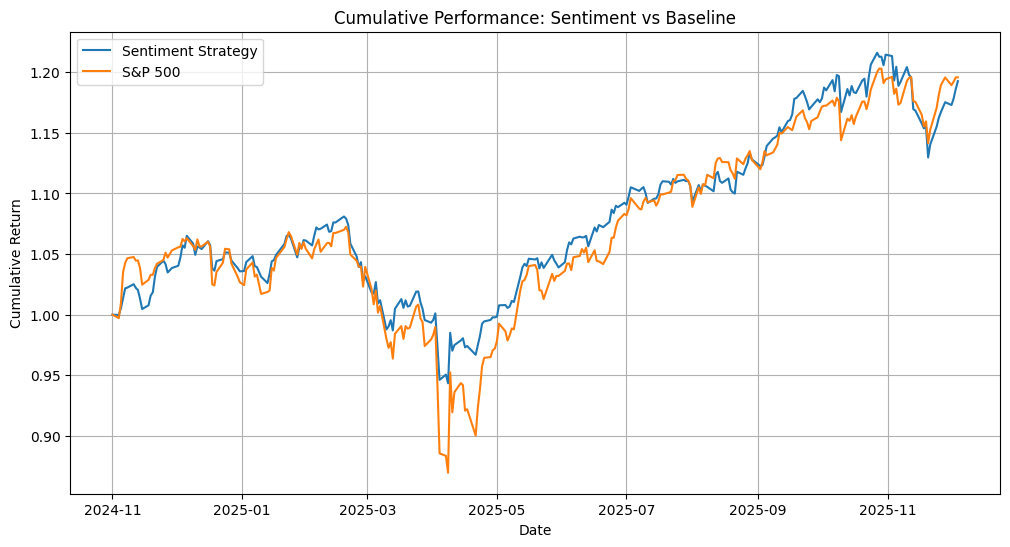

In [63]:
start_date = returns.index.min().strftime("%Y-%m-%d")
end_date   = returns.index.max().strftime("%Y-%m-%d")

spx = yf.download("^GSPC", start=start_date, end=end_date)
spx_ret = spx["Close"].pct_change()
spx_ret = spx_ret.reindex(returns.index)
spx_ret = spx_ret.fillna(0)
baseline_ret = spx_ret

def perf_stats(r):
    r = r.squeeze()
    cum = (1 + r).cumprod()
    ret = r.mean()
    std = r.std()
    sharpe = r.mean() / std * np.sqrt(252) if std != 0 else np.nan
    mdd = (cum / cum.cummax() - 1).min()
    return cum, sharpe, mdd, ret

strategy_cum, strategy_sharpe, strategy_mdd, strategy_ret = perf_stats(strategy_ret)
baseline_cum, baseline_sharpe, baseline_mdd, baseline_ret = perf_stats(baseline_ret)

#print("Sentiment strategy Mean Return:", strategy_ret)
print("Sentiment strategy Sharpe:", strategy_sharpe)
print("Sentiment strategy max drawdown:", strategy_mdd)
#print("Baseline Mean Return:", baseline_ret)
print("Baseline Sharpe:", baseline_sharpe)
print("Baseline max drawdown:", baseline_mdd)

plt.figure(figsize=(12, 6))
plt.plot(strategy_cum, label='Sentiment Strategy')
plt.plot(baseline_cum, label='S&P 500')
plt.legend()
plt.title('Cumulative Performance: Sentiment vs Baseline')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.show()

In [65]:
import statsmodels.api as sm

fwd_returns = returns.shift(-1)
signal_matrix = signal_matrix.iloc[:-1]
fwd_returns = fwd_returns.iloc[:-1]
signal_long = signal_matrix.stack().rename("signal")
ret_long = fwd_returns.stack().rename("fwd_ret")
reg_df = pd.concat([signal_long, ret_long], axis=1).dropna()
reg_df_news = reg_df[reg_df["signal"] != 0]
X_pooled = sm.add_constant(reg_df_news["signal"])
y_pooled = reg_df_news["fwd_ret"]

pooled_res = sm.OLS(y_pooled, X_pooled).fit(cov_type="HC1")
print(pooled_res.summary())

                            OLS Regression Results                            
Dep. Variable:                fwd_ret   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Sun, 14 Dec 2025   Prob (F-statistic):                nan
Time:                        20:09:17   Log-Likelihood:                 55341.
No. Observations:               28152   AIC:                        -1.107e+05
Df Residuals:                   28151   BIC:                        -1.107e+05
Df Model:                           0                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
signal         0.0013      0.000      6.302      0.0